In [1]:
import os
import xml.etree.ElementTree as ET
from natsort import natsorted
import pandas as pd
from PIL import Image
import numpy as np
import requests
from zipfile import ZipFile
from io import BytesIO
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import random
from six.moves import xrange
import collections
import string

In [2]:

def download_dataset(save_path):
    r = requests.get("http://cimalab.unal.edu.co/applications/thyroid/thyroid.zip")
    print("Downloading...")
    z = ZipFile(BytesIO(r.content))
    z.extractall(save_path)
    print("Completed...")

# XML and Jpeg
def to_dataframe(path):
    dirs=natsorted(os.listdir(path))
    xml_list=[]
    img_list=[]
    for i in range(len(dirs)):
        if '.xml' in dirs[i]:
            xml_list.append(dirs[i])
        if not '.xml'  in dirs[i]:
            img_list.append(dirs[i])
    xml_list=natsorted(xml_list)
    img_list=natsorted(img_list)
    tirads=[]
    for j in range(len(xml_list)):
        tree = ET.parse(path+'/'+xml_list[j])
        a=tree.findall("./tirads")
        if a[-1].text!=None:
            case=[xml_list[j],a[-1].text]
            tirads.append(case)
    data=[]
    for k in range(len(tirads)):
        xml=tirads[k][0][:-4]
        for z in range(len(img_list)):
            if xml+'_1.jpg'==img_list[z] or xml+'_2.jpg'==img_list[z] or xml+'_3.jpg'==img_list[z]:
                m=[img_list[z],tirads[k][1]]
                data.append(m)

    df = pd.DataFrame(data,columns =['Jpeg_Name', 'Tirads'])
    return df

#Cropp Function
def croping(img,x, y, w, h):
    if abs(w)<abs(h):
        img2=np.zeros([h,h])
        img2[:,h-w:h]=img[y:y+h, x:x+w]
    if abs(h)<abs(w):
        img2=np.zeros([w,w])
        img2[w-h:w,:]=img[y:y+h, x:x+w]
    else:
        return img
    return img2

def convert_one_channel(img):
    #if some images have 3 channels , although they are grayscale image
    if len(img.shape)>2:
        img=img[:,:,0]
        return img
    else:
        return img

#Remove Fill area from Image and Resizeing
def crop_resize(path,resize_shape):
    img=plt.imread(path)
    img=convert_one_channel(np.asarray(img))
    kernel =( np.ones((5,5), dtype=np.float32))
    ret,thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)
    thresh = thresh.astype(np.uint8)
    a1,b1=thresh.shape
    thresh=cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel,iterations=3 )
    thresh=cv2.erode(thresh,kernel,iterations =5)
    contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    c_area=np.zeros([len(contours)])
    for i in range(len(contours)):
        c_area[i]= cv2.contourArea(contours[i])
    cnts=contours[np.argmax(c_area)]
    x, y, w, h = cv2.boundingRect(cnts)
    roi = croping(img, x, y, w, h)
    roi=cv2.resize(roi,(resize_shape),interpolation=cv2.INTER_LANCZOS4)
    return roi


# TO Data Matrix
def to_imgmatrix(resize_shape,path,df):
    path=path+'/'
    images=crop_resize(path+df["Jpeg_Name"][0],resize_shape)
    for i in range (1,len(df["Jpeg_Name"])):
        img=crop_resize(path+df["Jpeg_Name"][i],resize_shape)
        images=np.concatenate((images,img))
    images=np.reshape(images,(len(df["Jpeg_Name"]),resize_shape[0],resize_shape[1],1))
    return images

def prepare_data(path,resize_shape):
    df=to_dataframe(path)
    data=to_imgmatrix(resize_shape,path,df)
    return df,data


# We need numeric category
def to_categoricalmatrix(df):
    #There are little categories, so i handled manually
    Y=np.zeros([len(df["Tirads"])])
    for i in range(len(df["Tirads"])):
        if df["Tirads"][i]=="2":
          Y[i]=0
        if df["Tirads"][i]=="3":
          Y[i]=1
        if df["Tirads"][i]=="4a":
          Y[i]=2
        if df["Tirads"][i]=="4b":
          Y[i]=3
        if df["Tirads"][i]=="4c":
          Y[i]=4
        if df["Tirads"][i]=="5":
          Y[i]=5
    return Y


In [3]:
download_dataset("C:\\Users\\abran\\Downloads\\thyroid")

Downloading...
Completed...


In [4]:
df,data=prepare_data("C:\\Users\\abran\\Downloads\\thyroid",(256,256))

In [5]:
df.shape

(347, 2)

In [6]:
df.head()

Jpeg_Name Tirads
0   2_1.jpg      2
1   3_1.jpg     4a
2   4_1.jpg     4a
3   5_1.jpg      5
4   6_1.jpg     4b

In [7]:
y = to_categoricalmatrix(df)

y = tf.keras.utils.to_categorical(y)


In [8]:
#normalize function
def normalize(data):
  for i in range(len(data)):
    data[i,:,:,:]=data[i,:,:,:]*(1/np.max(data[i,:,:,:]))
  return np.float32(data)

# we need noormalize to images
x=normalize(data)

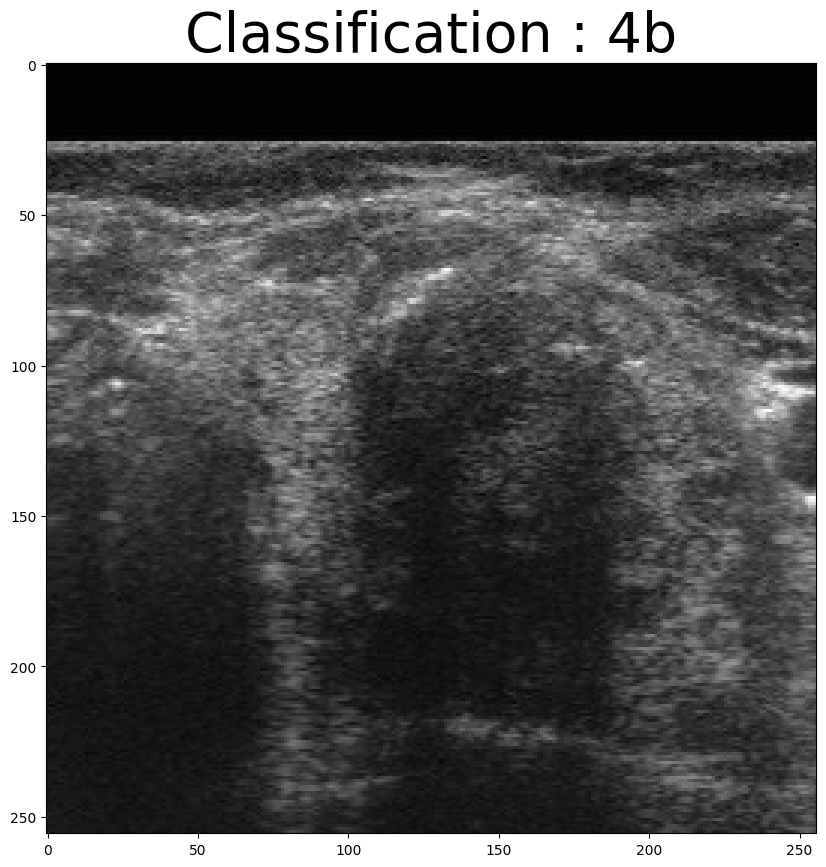

In [9]:
random_number2=random. randint(0,len(df["Tirads"]))
plt.figure(figsize = (20,10))
tit2 = "Classification : " + str(df["Tirads"][random_number2])
plt.title(tit2,fontsize = 40)
plt.imshow(x[random_number2,:,:,0],cmap="gray")

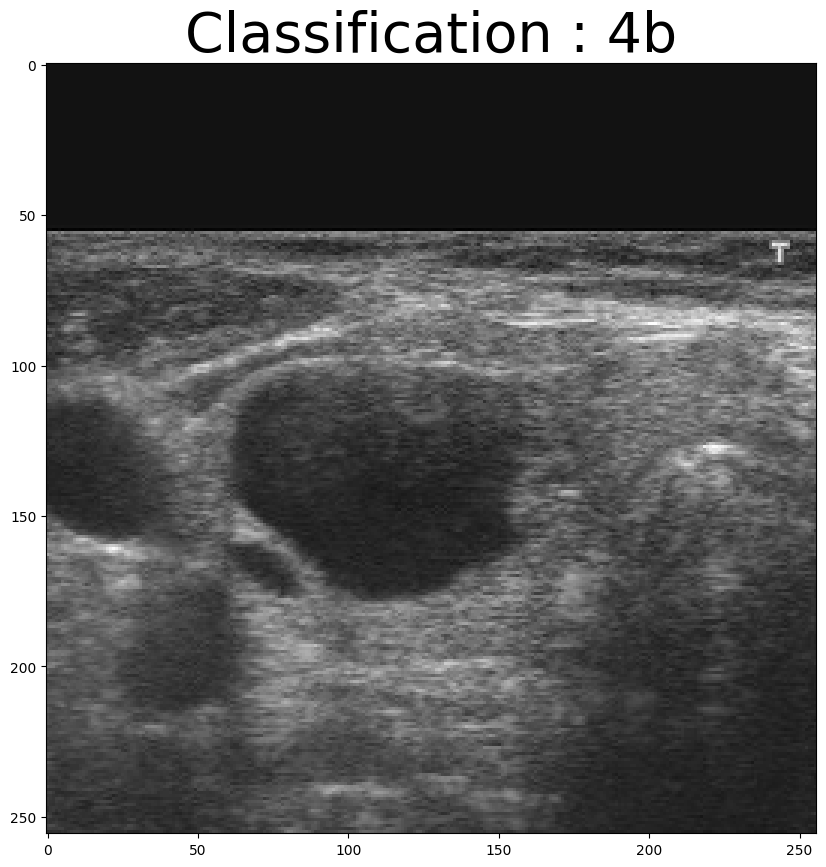

In [10]:
import random
random_number=random. randint(0,len(df["Tirads"]))
plt.figure(figsize = (20,10))
tit2 = "Classification : " + str(df["Tirads"][random_number2])
plt.title(tit2,fontsize = 40)
plt.imshow(x[random_number,:,:,0],cmap="gray")

In [11]:
#Splitting test and train
x_train=np.copy(x[:300,:,:,:])
x_test=np.copy(x[313:,:,:,:])
x_valid=np.copy(x[300:313,:,:,:])

y_train=np.copy(y[:300,:])
y_valid=np.copy(y[300:313,:])
y_test=np.copy(y[313:,:])

In [12]:
from tensorflow.keras import layers
#Data Augmention for to prevent Overfitting and to improve accuracy
data_augmentation1 = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.2), fill_mode="constant"),
    tf.keras.layers.RandomRotation(factor=(-0.2, 0.2), fill_mode="constant"),
    tf.keras.layers.RandomContrast(0.1)
])


x_train1=data_augmentation1(x_train)
y_train1=np.copy(y_train)
i=1

#22
while(i<22):
  x_aug=data_augmentation1(x)
  x_train1=np.concatenate((x_train1,x_aug),axis=0)
  y_aug=np.copy(y)
  y_train1=np.concatenate((y_train1,y_aug))

  #20
  if i == 20:
    break
  i += 1

In [13]:
#Efficient Net Model based https://github.com/SerdarHelli/TensorflowWorks
CONV_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 2.0,
        'mode': 'fan_out',
        'distribution': 'normal'
    }
}
BlockArgs = collections.namedtuple('BlockArgs', [
    'kernel_size', 'num_repeat', 'input_filters', 'output_filters',
    'expand_ratio', 'id_skip', 'strides', 'se_ratio'
])

BlockArgs.__new__.__defaults__ = (None,) * len(BlockArgs._fields)

DEFAULT_BLOCKS_ARGS = [
    BlockArgs(kernel_size=3, num_repeat=1, input_filters=32, output_filters=16,
              expand_ratio=1, id_skip=True, strides=[1, 1], se_ratio=0.25),
    BlockArgs(kernel_size=3, num_repeat=2, input_filters=16, output_filters=24,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(kernel_size=5, num_repeat=2, input_filters=24, output_filters=40,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(kernel_size=3, num_repeat=3, input_filters=40, output_filters=80,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(kernel_size=5, num_repeat=3, input_filters=80, output_filters=112,
              expand_ratio=6, id_skip=True, strides=[1, 1], se_ratio=0.25),
    BlockArgs(kernel_size=5, num_repeat=4, input_filters=112, output_filters=192,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(kernel_size=3, num_repeat=1, input_filters=192, output_filters=320,
              expand_ratio=6, id_skip=True, strides=[1, 1], se_ratio=0.25)
]

## Our MB_CONV_Block
def mb_conv_block(inputs,block_args,drop_rate):
  ##Mobile Inverted Residual block along with Squeeze  and Excitation block.
    kernel_size = block_args.kernel_size
    num_repeat= block_args.num_repeat
    input_filters= block_args.input_filters
    output_filters=block_args. output_filters
    expand_ratio= block_args.expand_ratio
    id_skip= block_args.id_skip
    strides= block_args.strides
    se_ratio= block_args.se_ratio
    # expansion phase
    expanded_filters = input_filters * expand_ratio
    x=tf.keras.layers.Conv2D(filters=expanded_filters, kernel_size=(1,1), padding="same",use_bias=False,kernel_initializer=CONV_KERNEL_INITIALIZER,)(inputs)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.activations.swish(x)
    # Depthwise convolution phase
    x_depth=tf.keras.layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same",strides=strides, use_bias=False,kernel_initializer=CONV_KERNEL_INITIALIZER,)(x)
    x=tf.keras.layers.BatchNormalization()(x_depth)
    x=tf.keras.activations.swish(x)
    #SE Block
    x =tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Reshape((1,1, expanded_filters ))(x)
    squeezed_filters = max (1, int(input_filters * se_ratio))
    x=tf.keras.layers.Conv2D(filters=squeezed_filters, kernel_size=(1,1),padding="same",kernel_initializer=CONV_KERNEL_INITIALIZER,)(x)
    x=tf.keras.activations.swish(x)
    x=tf.keras.layers.Conv2D(filters=expanded_filters, kernel_size=(1,1),padding="same",kernel_initializer=CONV_KERNEL_INITIALIZER,)(x)
    x=tf.keras.activations.sigmoid(x)
    x=tf.keras.layers.Multiply()([x_depth,x])
    #SE Block
    x=tf.keras.layers.Conv2D(filters=output_filters, kernel_size=(1,1),padding="same",use_bias=False,kernel_initializer=CONV_KERNEL_INITIALIZER,)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.Dropout(drop_rate)(x)
    if id_skip and all( s == 1 for s in strides) and input_filters == output_filters:
      x=tf.keras.layers.Add()([inputs,x])
    return x

def round_filters(filters, width_coefficient, depth_divisor):
    """Round number of filters based on width multiplier."""
    filters *= width_coefficient
    new_filters = int(filters + depth_divisor / 2) // depth_divisor * depth_divisor
    new_filters = max(depth_divisor, new_filters)
    # Make sure that round down does not go down by more than 10%.
    if new_filters < 0.9 * filters:
        new_filters += depth_divisor
    return int(new_filters)


def round_repeats(repeats, depth_coefficient):
    """Round number of repeats based on depth multiplier."""
    return int(math.ceil(depth_coefficient * repeats))

def EfficientNet(width_coefficient,
                 depth_coefficient,
                 default_resolution,
                 dropout_rate=0.2,
                 drop_connect_rate=0.2,
                 depth_divisor=8,
                 model_name='efficientnet',
                 weights='imagenet',
                 input_shape=None,
                 blocks_args=DEFAULT_BLOCKS_ARGS,
                 **kwargs):


  #### Stem
  inputs = tf.keras.layers.Input(shape=(input_shape))
  x = tf.keras.layers.Conv2D(round_filters(32, width_coefficient, depth_divisor), 3,
                      strides=(2, 2),
                      padding='same',
                      use_bias=False,
                      name='stem_conv',kernel_initializer=CONV_KERNEL_INITIALIZER,)(inputs)
  x = tf.keras.layers.BatchNormalization( name='stem_bn')(x)
  x=tf.keras.activations.swish(x)
  num_blocks_total = sum(block_args.num_repeat for block_args in blocks_args)
  block_num = 0
  for idx, block_args in enumerate(blocks_args):
      assert block_args.num_repeat > 0
      # Update block input and output filters based on depth multiplier.
      block_args = block_args._replace(
          input_filters=round_filters(block_args.input_filters,
                                      width_coefficient, depth_divisor),
          output_filters=round_filters(block_args.output_filters,
                                        width_coefficient, depth_divisor),
          num_repeat=round_repeats(block_args.num_repeat, depth_coefficient))

      # The first block needs to take care of stride and filter size increase.
      drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
      x = mb_conv_block(x, block_args,
                        drop_rate=drop_rate)
      block_num += 1
      if block_args.num_repeat > 1:
          # pylint: disable=protected-access
          block_args = block_args._replace(
              input_filters=block_args.output_filters, strides=(1, 1))
          # pylint: enable=protected-access
          for bidx in xrange(block_args.num_repeat - 1):
              drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
              block_prefix = 'block{}{}_'.format(
                  idx + 1,
                  string.ascii_lowercase[bidx + 1]
              )
              x = mb_conv_block(x, block_args,
                                drop_rate=drop_rate)
              block_num += 1
  x = tf.keras.layers.Conv2D(round_filters(1280, width_coefficient, depth_divisor), 1,
                      padding='same',
                      use_bias=False,
                      name='top_conv',kernel_initializer=CONV_KERNEL_INITIALIZER,)(x)
  x = tf.keras.layers.BatchNormalization(name='top_bn')(x)
  x=tf.keras.activations.swish(x)
  return tf.keras.Model(inputs, x, name=model_name)




def EfficientNetB0(
        input_tensor=None,
        input_shape=None,
        **kwargs
):
    return EfficientNet(
        1.0, 1.0, 224, 0.2,
        model_name='efficientnet-b0',
        input_tensor=input_tensor, input_shape=input_shape,
        **kwargs
    )


def EfficientNetB1(
        input_tensor=None,
        input_shape=None,
        **kwargs
        ):
    return EfficientNet(
        1.0, 1.1, 240, 0.2,
        model_name='efficientnet-b1',
        input_tensor=input_tensor, input_shape=input_shape,
        **kwargs
    )


def EfficientNetB2(
                   input_tensor=None,
                   input_shape=None,
                   **kwargs
                   ):
    return EfficientNet(
        1.1, 1.2, 260, 0.3,
        model_name='efficientnet-b2',
        input_tensor=input_tensor, input_shape=input_shape,
        **kwargs
    )


def EfficientNetB3(
                   input_tensor=None,
                   input_shape=None,**kwargs
                   ):
    return EfficientNet(
        1.2, 1.4, 300, 0.3,
        model_name='efficientnet-b3',
        input_tensor=input_tensor, input_shape=input_shape,
        **kwargs
    )


def EfficientNetB4(
        input_tensor=None,
        input_shape=None,
        **kwargs
        ):
    return EfficientNet(
        1.4, 1.8, 380, 0.4,
        model_name='efficientnet-b4',
        input_tensor=input_tensor, input_shape=input_shape,
        **kwargs
    )


def EfficientNetB5(
        input_tensor=None,
        input_shape=None,
        **kwargs
        ):
    return EfficientNet(
        1.6, 2.2, 456, 0.4,
        model_name='efficient3dnet-b5',
        input_tensor=input_tensor, input_shape=input_shape,
        **kwargs
    )

def EfficientNetB6(
        input_tensor=None,
        input_shape=None,
        **kwargs
        ):
    return EfficientNet(
        1.8, 2.6, 528, 0.5,
        model_name='efficientnet-b6',
        input_tensor=input_tensor, input_shape=input_shape,

        **kwargs
    )


def EfficientNetB7(
        input_tensor=None,
        input_shape=None,
        **kwargs
        ):
    return EfficientNet(
        2.0, 3.1, 600, 0.5,
        model_name='efficientnet-b7',
        input_tensor=input_tensor, input_shape=input_shape,
        **kwargs
    )

def EfficientNetL2(
        input_tensor=None,
        input_shape=None,
        **kwargs
        ):
    return EfficientNet(
        4.3, 5.3, 800, 0.5,
        model_name='efficientnet-l2',
        input_tensor=input_tensor, input_shape=input_shape,
        **kwargs
    )

In [14]:
def VGG19(input_shape,filters):
    inputs=tf.keras.layers.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(filters//16,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    x=tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv2D(filters//16,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.BatchNormalization()(x)



    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(filters//8,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv2D(filters//8,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(filters//4,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Conv2D(filters//4,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters//4,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(filters//2,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Conv2D(filters//2,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters//2,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(filters,(3,3),activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Conv2D(filters,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.BatchNormalization()(x)
    last = tf.keras.layers.Conv2D(filters,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',name='top_conv')(x)

    model=tf.keras.Model(inputs,last,name="VGG19")
    return model



In [15]:
def check_balance(y):
  malign=0
  benign=0
  for i in range(len(y)):
    if y[i]<2:
      benign=benign+1
    else :
      malign=malign+1
  print("Maling Count :" , malign)
  print("Benign Count :" , benign)
  return malign,benign



In [16]:
base_model=VGG19(input_shape=(256,256,1),filters=512)
x = base_model.output
f=tf.keras.layers.Flatten(name="flatten")(x)
d2=tf.keras.layers.Dense(1024,activation="relu",kernel_regularizer=tf.keras.regularizers.l1_l2(0.00001))(f)
dp9=tf.keras.layers.Dropout(0.5)(d2)
d3=tf.keras.layers.Dense(1024,activation="relu")(f)
dp10=tf.keras.layers.Dropout(0.5)(d2)

final=tf.keras.layers.Dense(6,activation="softmax")(dp10)
model = tf.keras.Model( inputs =[ base_model.input], outputs = final)


In [17]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 256, 256, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 142,039,526 (541.84 MB)

 Trainable params: 142,036,774 (541.83 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [18]:
metrics=tf.keras.metrics.AUC(
    num_thresholds=200, curve='ROC',
    summation_method='interpolation'
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=[tf.keras.metrics.AUC(name='auc')])


def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 15
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

lr_call = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
epochs=50
history=model.fit(x=[x_train1],y=[y_train1],batch_size=16,epochs=epochs,callbacks=[lr_call],validation_data=(x_valid,y_valid))

Epoch 1/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 45s 58ms/step - auc: 0.5738 - loss: 9.1731 - val_auc: 0.4769 - val_loss: 5.1611 - learning_rate: 1.0000e-04
Epoch 2/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - auc: 0.6217 - loss: 4.7502 - val_auc: 0.4136 - val_loss: 4.4357 - learning_rate: 1.0000e-04
Epoch 3/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - auc: 0.6477 - loss: 4.0218 - val_auc: 0.3811 - val_loss: 3.9319 - learning_rate: 1.0000e-04
Epoch 4/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - auc: 0.6492 - loss: 3.4874 - val_auc: 0.3923 - val_loss: 3.5680 - learning_rate: 1.0000e-04
Epoch 5/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - auc: 0.6466 - loss: 3.0661 - val_auc: 0.4639 - val_loss: 3.1121 - learning_rate: 1.0000e-04
Epoch 6/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - auc: 0.6519 - loss: 2.7466 - val_auc: 0.4130 - val_loss: 2.6863 - learning_rate: 1.0000e-04
Epoch 7/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - auc: 0.6585 - loss: 2.4857 - val_auc: 0.4071 - val_loss:

In [19]:
from sklearn.metrics import confusion_matrix
predict=model.predict(x_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


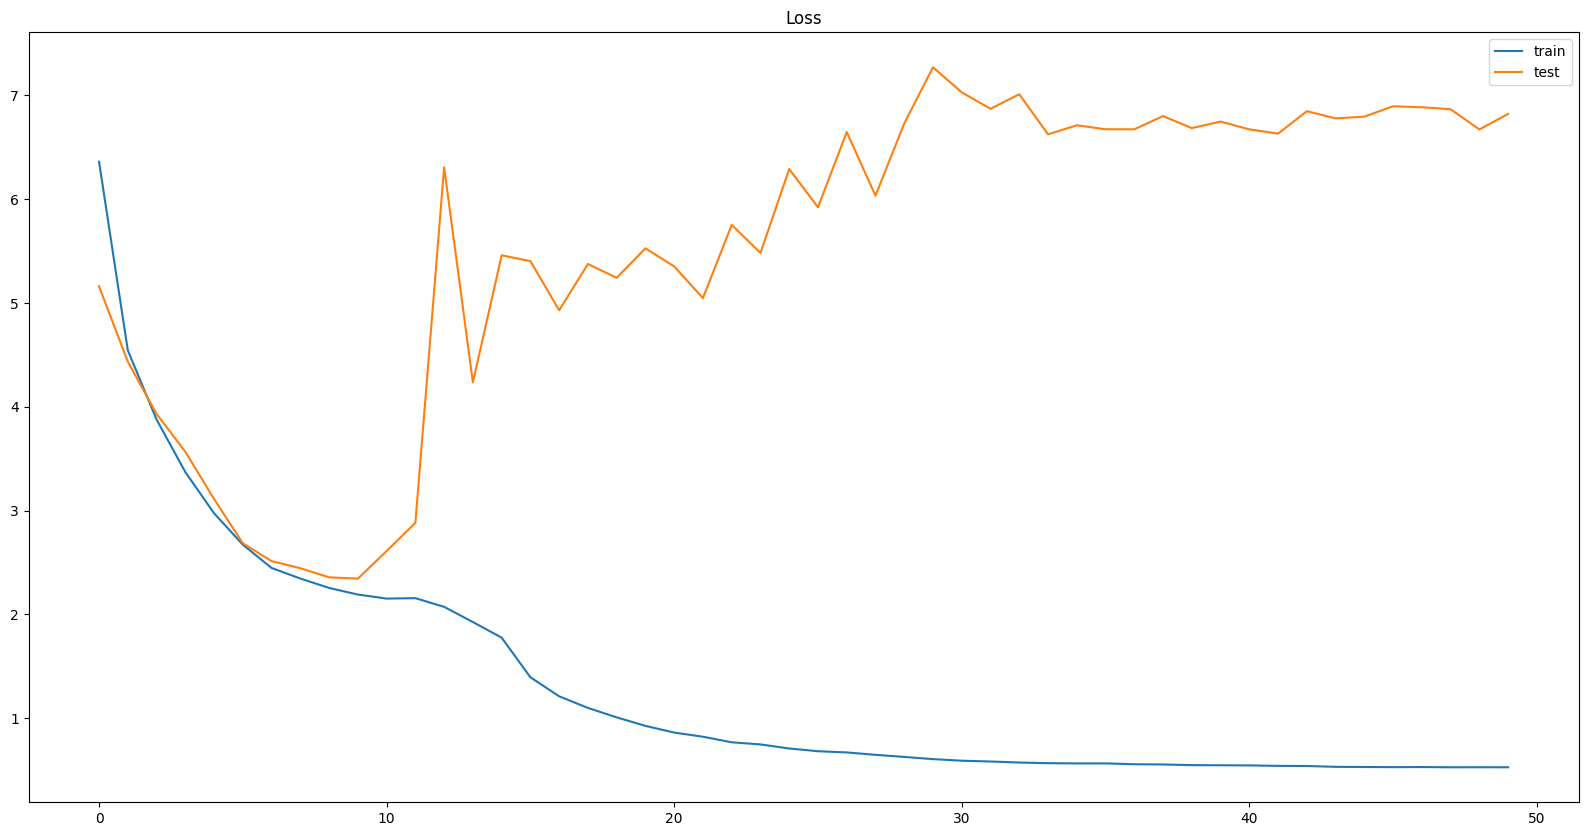

In [20]:
plt.figure(figsize = (20,10))
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [21]:
import sklearn
from sklearn.metrics import accuracy_score

auc = sklearn.metrics.roc_auc_score(y_test, predict)

In [22]:
y_test=np.reshape(y_test,(34*6))
predict=np.reshape(predict,(34*6))

No Skill: ROC AUC=0.500
Model: ROC AUC=0.650


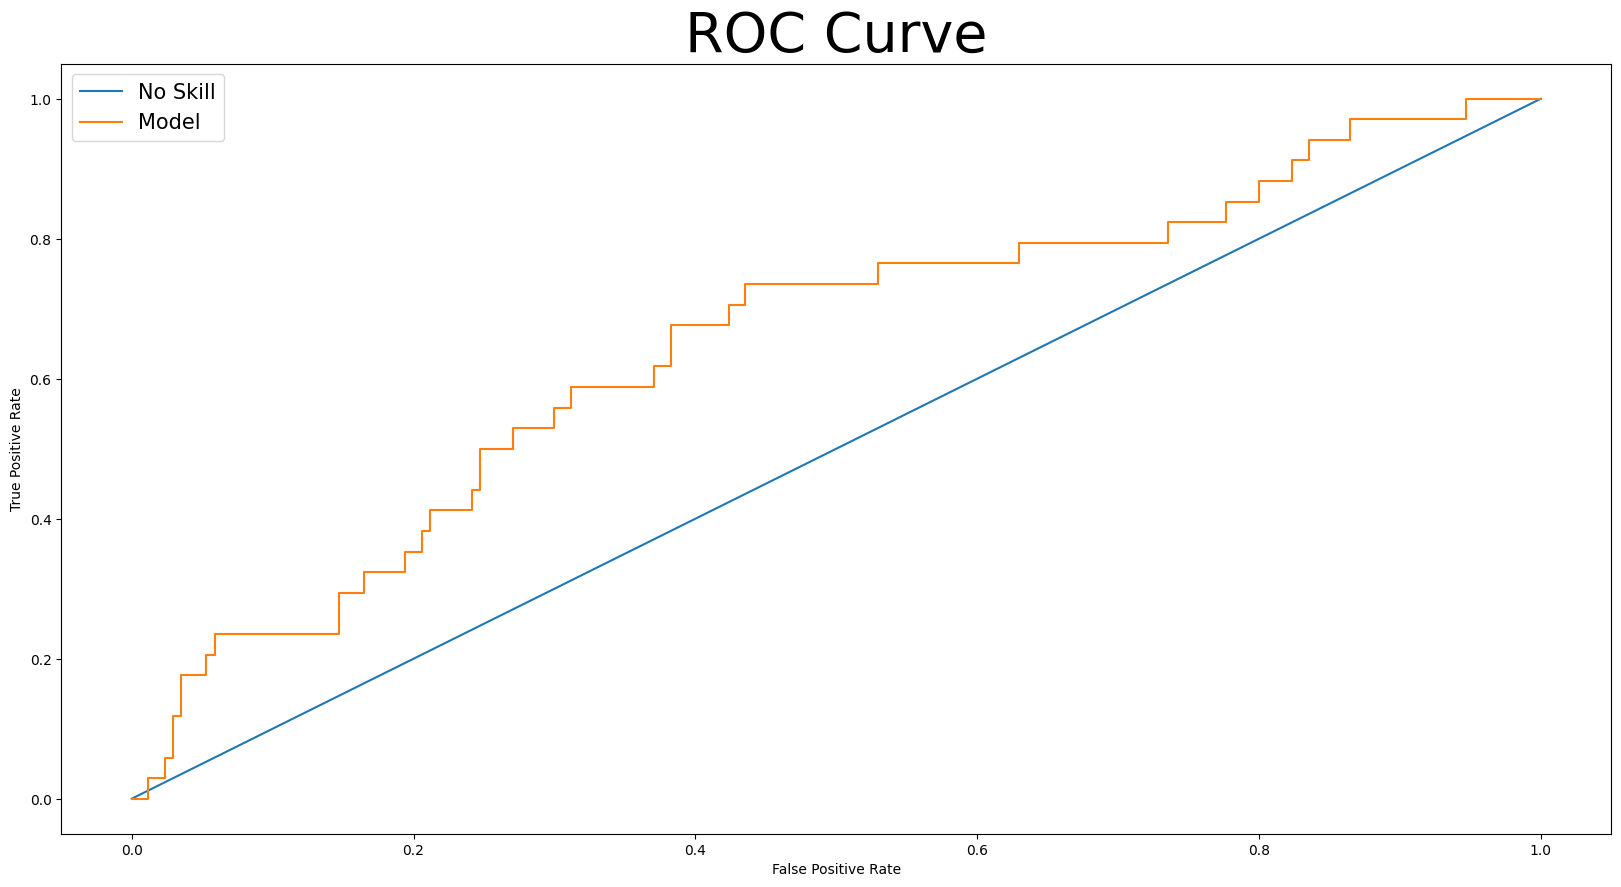

In [23]:

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, predict)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Model: ROC AUC=%.3f' % (lr_auc))
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, predict)
plt.figure(figsize = (20,10))
plt.title("ROC Curve",fontsize = 40)
plt.plot(ns_fpr, ns_tpr,label='No Skill')
plt.plot(lr_fpr, lr_tpr, label='Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.rcParams["font.size"] = "15"

plt.legend()
plt.show()

In [24]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names ):

    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)
    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(last_conv_layer_output, axis=-1)

    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [25]:
from tensorflow import keras
img_array=x_test[0,:,:,:]

img_array=np.reshape(img_array,(1,256,256,1))
preds = model.predict(img_array)
last_conv_layer_name = "top_conv"
classifier_layer_names = ["flatten"]

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)
img = keras.preprocessing.image.img_to_array(x_test[0,:,:,:])
import matplotlib.cm as cm
# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)
# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")
# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]
# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
# Superimpose the heatmap on original image
img2=np.zeros([256,256,3])
img2[:,:,0]=img[:,:,0]
superimposed_img = jet_heatmap * 0.0025 + img2
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
superimposed_img=np.uint8(superimposed_img)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step


<ipython-input-25-707f3da4a81e>:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


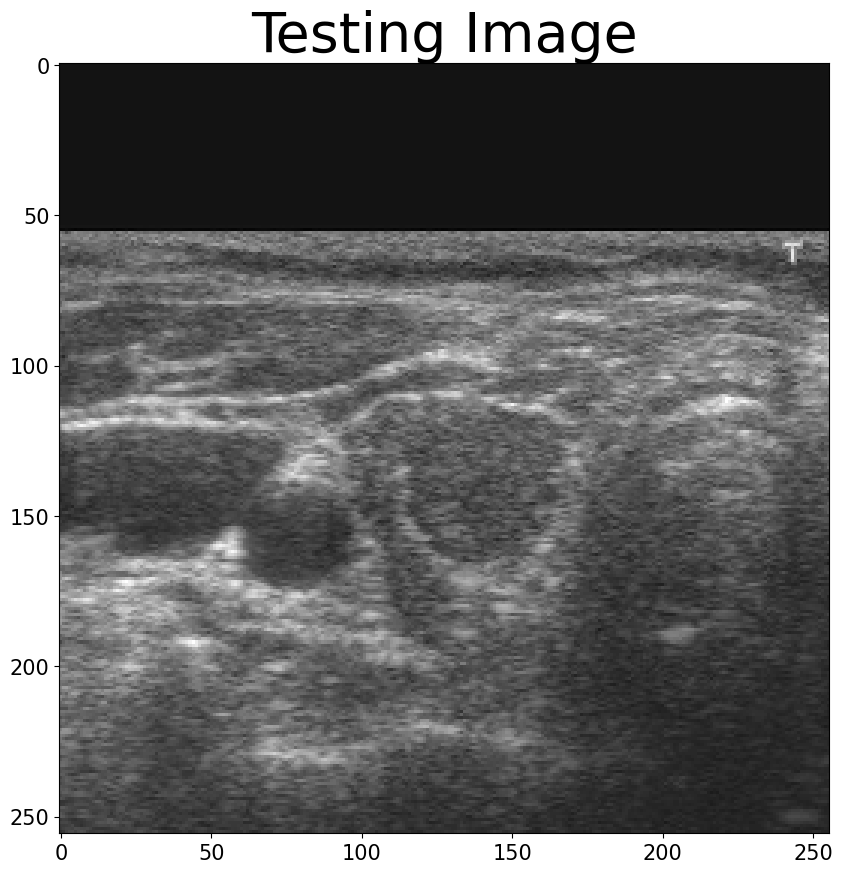

In [26]:
plt.figure(figsize = (20,10))
plt.title("Testing Image",fontsize = 40)
plt.imshow(img_array[0,:,:,:],cmap="gray")

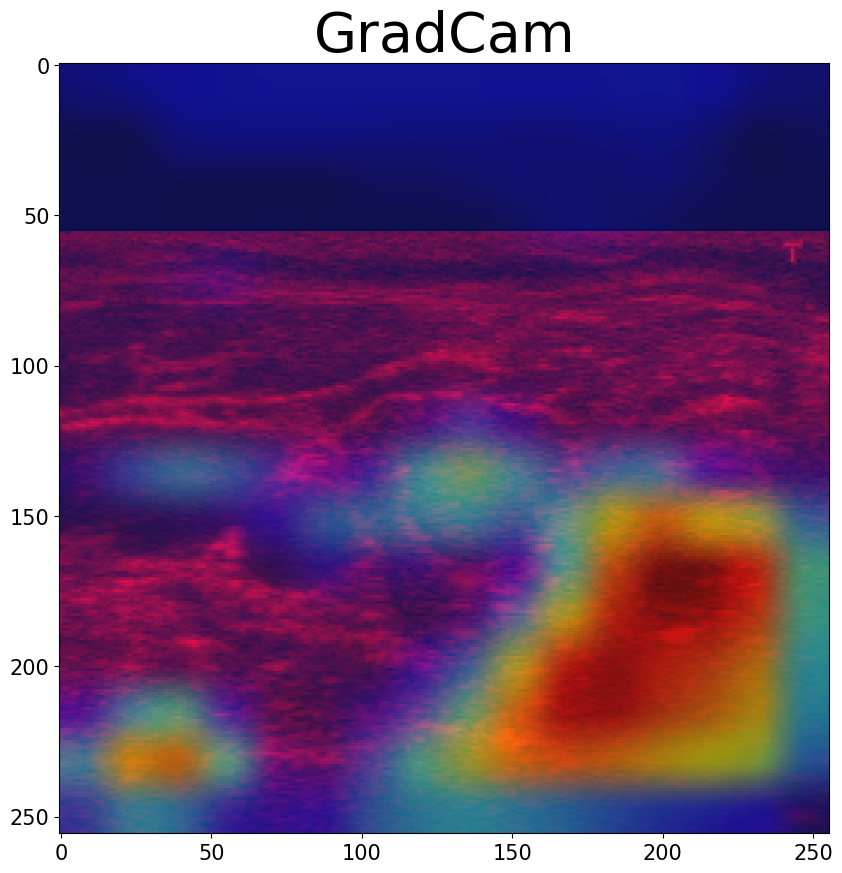

In [27]:
plt.figure(figsize = (20,10))
plt.title("GradCam",fontsize = 40)
plt.imshow(superimposed_img)

In [28]:
vgg19 = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
feature_extractor = tf.keras.Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)

In [29]:
from tensorflow.keras import layers, Model
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

In [30]:
from tensorflow.keras import layers, Model
import tensorflow as tf

# Step 1: Custom Layer for Extracting Patches
class PatchExtractor(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtractor, self).__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, inputs):
        patches = tf.image.extract_patches(
            images=inputs,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        patch_dim = self.patch_size * self.patch_size
        patches = tf.reshape(patches, [-1, patches.shape[1] * patches.shape[2], patch_dim])
        return patches



In [31]:
#Step 2: Define Vision Transformer Model
def vision_transformer(input_shape, num_classes, patch_size=16, projection_dim=64, num_heads=4, transformer_layers=8, mlp_head_units=[128, 64]):
    inputs = layers.Input(shape=input_shape)

    # Step 2.1: Split image into patches using the custom layer
    patches = PatchExtractor(patch_size)(inputs)

    # Step 2.2: Add position embeddings
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    positions = tf.range(start=0, limit=num_patches, delta=1)
    position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)(positions)
    patches = layers.Dense(projection_dim)(patches)
    encoded_patches = patches + position_embedding

    # Step 2.3: Transformer Layers
    for _ in range(transformer_layers):
        # Multi-Head Attention
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])

        # MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = layers.Dense(projection_dim * 2, activation=tf.nn.gelu)(x3)
        x3 = layers.Dense(projection_dim)(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Step 2.4: Classification Head
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    for units in mlp_head_units:
        representation = layers.Dense(units, activation=tf.nn.gelu)(representation)
    logits = layers.Dense(num_classes, activation="softmax")(representation)

    return Model(inputs=inputs, outputs=logits, name="VisionTransformer")

In [32]:
# Step 3: Instantiate and Train Vision Transformer
vit_model = vision_transformer(input_shape=(256, 256, 1), num_classes=6)
vit_model.summary()
vit_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss="categorical_crossentropy",
                  metrics=[tf.keras.metrics.AUC(name='auc')])

history_vit = vit_model.fit(
    x=x_train1,
    y=y_train1,
    batch_size=16,
    epochs=50,
    validation_data=(x_valid, y_valid),
    callbacks=[lr_call]
)

Model: "VisionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_extractor           │ (None, 256, 256)       │              0 │ input_layer_4[0][0]    │
│ (PatchExtractor)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256, 64)        │         16,448 │ patch_extractor[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256, 64)        │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 256, 64)        │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 256, 64)        │         66,368 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 256, 64)        │              0 │ multi_head_attention[… │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 256, 64)        │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256, 128)       │          8,320 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 256, 64)        │          8,256 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 256, 64)        │              0 │ dense_5[0][0],         │
│                           │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 256, 64)        │            128 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 256, 64)        │         66,368 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 256, 64)        │              0 │ multi_head_attention_… │
│                           │                        │                │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3

 Total params: 2,788,102 (10.64 MB)

 Trainable params: 2,788,102 (10.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 98s 102ms/step - auc: 0.6399 - loss: 1.7527 - val_auc: 0.4680 - val_loss: 1.9825 - learning_rate: 1.0000e-04
Epoch 2/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - auc: 0.7015 - loss: 1.6021 - val_auc: 0.4834 - val_loss: 2.0418 - learning_rate: 1.0000e-04
Epoch 3/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - auc: 0.7425 - loss: 1.5111 - val_auc: 0.5905 - val_loss: 1.9047 - learning_rate: 1.0000e-04
Epoch 4/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - auc: 0.8061 - loss: 1.3550 - val_auc: 0.5976 - val_loss: 1.8070 - learning_rate: 1.0000e-04
Epoch 5/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - auc: 0.8670 - loss: 1.1671 - val_auc: 0.7657 - val_loss: 1.6100 - learning_rate: 1.0000e-04
Epoch 6/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - auc: 0.9192 - loss: 0.9482 - val_auc: 0.7929 - val_loss: 1.4250 - learning_rate: 1.0000e-04
Epoch 7/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - auc: 0.9589 - loss: 0.7239 - val_auc: 0.7870 - val_loss: 1.57

In [33]:
# Step 4: Evaluate and Visualize
vit_predict = vit_model.predict(x_test)
vit_auc = roc_auc_score(y_test.flatten(), vit_predict.flatten())

2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 9s/step


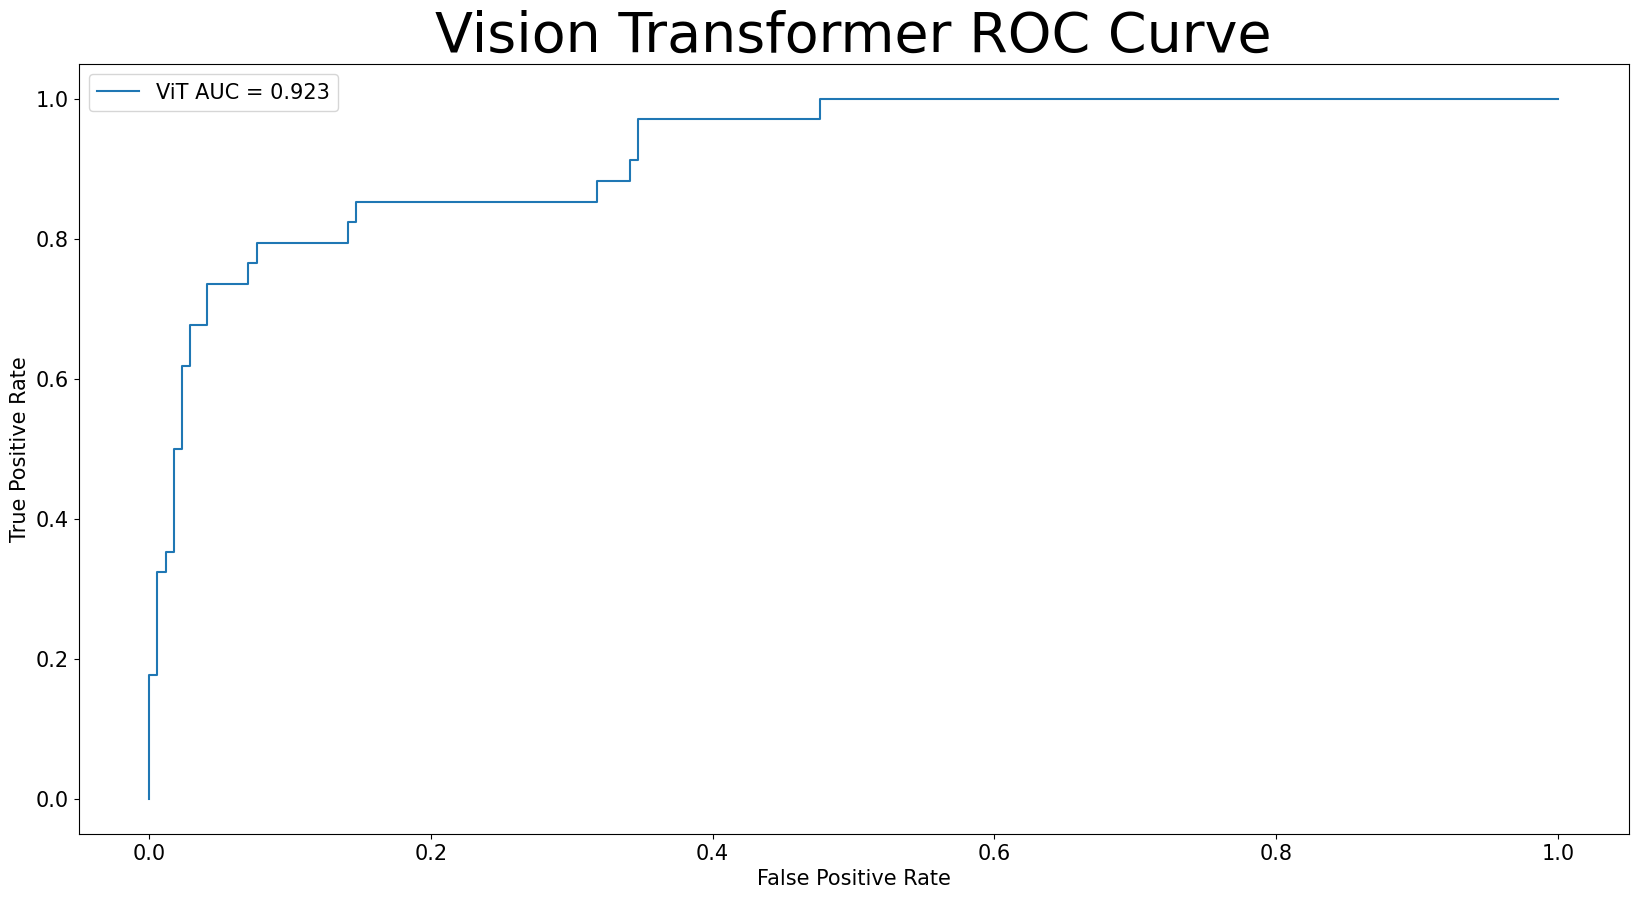

In [34]:
# Plot ROC Curve
vit_fpr, vit_tpr, _ = roc_curve(y_test.flatten(), vit_predict.flatten())
plt.figure(figsize=(20, 10))
plt.title("Vision Transformer ROC Curve", fontsize=40)
plt.plot(vit_fpr, vit_tpr, label=f'ViT AUC = {vit_auc:.3f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [35]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def make_gradcam_heatmap_vit(img_array, model, attention_layer_name, classifier_layer_names):
    """
    Generates a Grad-CAM heatmap for Vision Transformer.
    Arguments:
    - img_array: Input image array.
    - model: Trained Vision Transformer model.
    - attention_layer_name: Name of the attention layer in the model.
    - classifier_layer_names: List of classifier layers following the attention block.

    Returns:
    - heatmap: Grad-CAM heatmap.
    """
    # Extract the attention block output
    attention_layer = model.get_layer(attention_layer_name)
    attention_model = keras.Model(model.inputs, attention_layer.output)

    # Extract the classifier portion of the model
    classifier_input = keras.Input(shape=attention_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Compute gradients
    with tf.GradientTape() as tape:
        attention_output = attention_model(img_array)
        tape.watch(attention_output)
        preds = classifier_model(attention_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    grads = tape.gradient(top_class_channel, attention_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    # Create heatmap
    attention_output = attention_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        attention_output[:, i] *= pooled_grads[i]
    heatmap = np.mean(attention_output, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    return heatmap

# Example Usage
img_array = np.expand_dims(x_test[0], axis=0)  # Single test image
attention_layer_name = "multi_head_attention_7"  # Last Multi-Head Attention Layer
classifier_layer_names = ["layer_normalization_16", "flatten", "dense_20", "dense_21", "dense_22"]  # Classifier layers

# Generate Grad-CAM heatmap
heatmap = make_gradcam_heatmap_vit(
    img_array, vit_model, attention_layer_name, classifier_layer_names
)





In [36]:
def visualize_gradcam(img_array, heatmap):
    """
    Visualizes Grad-CAM by overlaying the heatmap on the original image.
    Arguments:
    - img_array: Original grayscale input image (4D batch with shape (1, H, W, 1)).
    - heatmap: Grad-CAM heatmap (2D array).

    Returns:
    - superimposed_img: RGB image with the heatmap overlay.
    """
    import matplotlib

    # Normalize the heatmap to range [0, 255] and convert to RGB
    heatmap = np.uint8(255 * heatmap)
    jet = matplotlib.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Resize heatmap to match the original image size
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array.shape[1], img_array.shape[2]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Ensure grayscale input image has 3 channels
    img_rgb = np.stack((img_array[0, :, :, 0],) * 3, axis=-1)

    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * 0.4 + img_rgb
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img


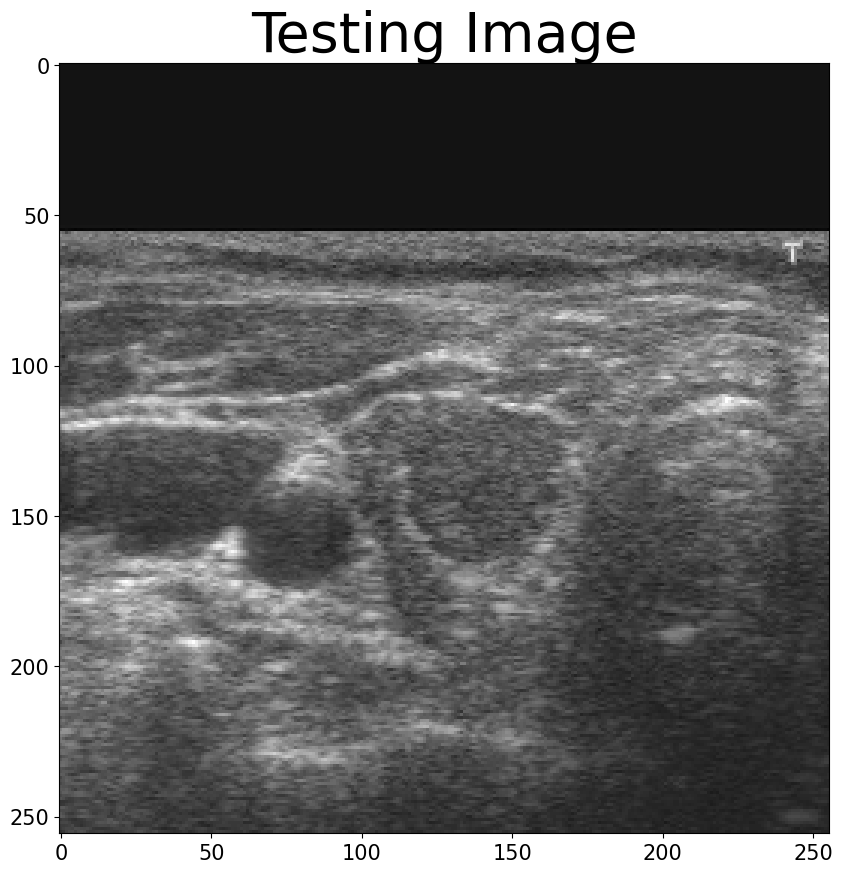

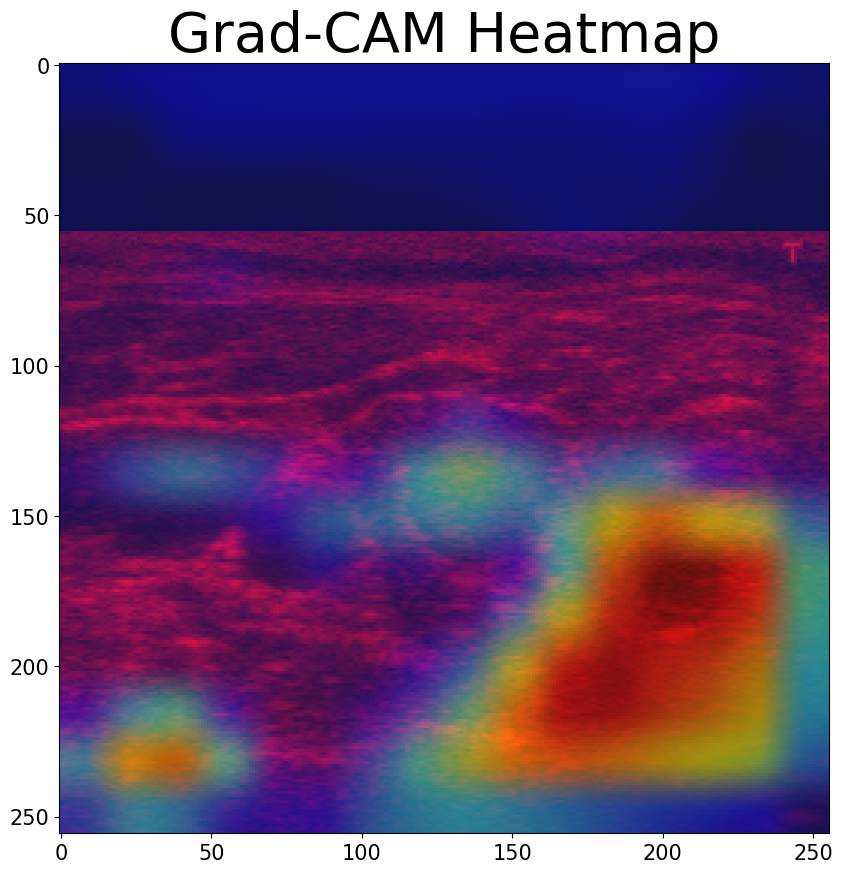

In [37]:
# Display Results
plt.figure(figsize=(20, 10))
plt.title("Testing Image", fontsize=40)
plt.imshow(np.squeeze(x_test[0]), cmap="gray")

plt.figure(figsize=(20, 10))
plt.title("Grad-CAM Heatmap", fontsize=40)
plt.imshow(superimposed_img)

In [38]:
def dice_coefficient(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred > threshold).astype(int)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))

# Example usage:
dice_score = dice_coefficient(y_test.flatten(), vit_predict.flatten())
print(f"Dice Coefficient: {dice_score:.2f}")


Dice Coefficient: 0.76


In [39]:
def iou_score(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred > threshold).astype(int)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true + y_pred) - intersection
    return intersection / union

# Example usage:
iou = iou_score(y_test.flatten(), vit_predict.flatten())
print(f"Intersection over Union (IoU): {iou:.2f}")


Intersection over Union (IoU): 0.61


In [40]:
print(f"y_test: {y_test.shape}, vit_predict: {vit_predict.shape}")


y_test: (204,), vit_predict: (34, 6)


In [41]:
y_test = y_test[:vit_predict.shape[0]]


In [42]:
# Ensure predictions are properly shaped
vit_predict = vit_model.predict(x_test)
print(f"Shape of vit_predict: {vit_predict.shape}")

# If predictions are probabilities, convert to class indices
if len(vit_predict.shape) == 2:  # Probabilities
    y_pred_classes = vit_predict.argmax(axis=1)
else:  # Already class indices
    y_pred_classes = vit_predict

# Ensure y_test matches the number of predictions
if len(y_test) != len(y_pred_classes):
    y_test = y_test[:len(y_pred_classes)]

# Calculate sensitivity
from sklearn.metrics import recall_score
sensitivity = recall_score(y_test, y_pred_classes, average='macro')
print(f"Sensitivity: {sensitivity:.2f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Shape of vit_predict: (34, 6)
Sensitivity: 0.07


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [43]:
from sklearn.metrics import recall_score, confusion_matrix
import numpy as np

# Ensure predictions are properly shaped
vit_predict = vit_model.predict(x_test)
if len(vit_predict.shape) == 2:  # Probabilities
    y_pred_classes = vit_predict.argmax(axis=1)
else:  # Already class indices
    y_pred_classes = vit_predict

# Ensure y_test matches the number of predictions
if len(y_test) != len(y_pred_classes):
    y_test = y_test[:len(y_pred_classes)]

# Sensitivity Calculation
sensitivity = recall_score(y_test, y_pred_classes, average='macro')
print(f"Sensitivity: {sensitivity:.2f}")

# Specificity Calculation
def compute_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    # Calculate TN and FP
    tn = np.sum(np.diag(cm)) - np.sum(cm.sum(axis=0) - np.diag(cm))
    fp = np.sum(cm.sum(axis=0) - np.diag(cm))
    specificity = tn / (tn + fp)
    return specificity

specificity = compute_specificity(y_test, y_pred_classes)
print(f"Specificity: {specificity:.2f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Sensitivity: 0.07
Specificity: -2.25


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [44]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_metrics = []

for train_idx, val_idx in kf.split(x_train1):
    x_train_fold, x_val_fold = x_train1[train_idx], x_train1[val_idx]
    y_train_fold, y_val_fold = y_train1[train_idx], y_train1[val_idx]

    # Train the model
    vit_model.fit(x_train_fold, y_train_fold, epochs=10, verbose=0)

    # Evaluate the model on the validation fold
    val_preds = vit_model.predict(x_val_fold)
    auc = roc_auc_score(y_val_fold.flatten(), val_preds.flatten())
    fold_metrics.append(auc)

print(f"Cross-Validation AUC Scores: {fold_metrics}")
print(f"Mean AUC Score: {np.mean(fold_metrics):.2f}")


46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Cross-Validation AUC Scores: [0.9999999999999999, 1.0, 1.0, 1.0, 1.0]
Mean AUC Score: 1.00


In [45]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import numpy as np


In [46]:
class VisionTransformer(Model):
    def __init__(self, image_size, patch_size, num_classes, embed_dim, depth, num_heads, mlp_dim, dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.num_patches = (image_size // patch_size) ** 2
        self.patch_dim = (patch_size ** 2)

        # Patch Embedding
        self.patch_embed = layers.Dense(embed_dim)
        self.cls_token = tf.Variable(tf.random.normal([1, 1, embed_dim]))
        self.positional_encoding = tf.Variable(tf.random.normal([1, self.num_patches + 1, embed_dim]))

        # Transformer Blocks
        self.transformer_blocks = [
            layers.TransformerBlock(embed_dim, num_heads, mlp_dim, dropout)
            for _ in range(depth)
        ]

        # Classification Head
        self.mlp_head = tf.keras.Sequential([
            layers.LayerNormalization(epsilon=1e-6),
            layers.Dense(mlp_dim, activation='gelu'),
            layers.Dropout(dropout),
            layers.Dense(num_classes)
        ])

    def call(self, x):
        # Convert image to patches
        x = tf.image.extract_patches(
            images=x,
            sizes=[1, self.patch_dim, self.patch_dim, 1],
            strides=[1, self.patch_dim, self.patch_dim, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        x = tf.reshape(x, [-1, self.num_patches, self.patch_dim])
        x = self.patch_embed(x)

        # Add CLS token and positional encoding
        cls_tokens = tf.broadcast_to(self.cls_token, [tf.shape(x)[0], 1, self.embed_dim])
        x = tf.concat([cls_tokens, x], axis=1)
        x += self.positional_encoding

        # Transformer layers
        for transformer in self.transformer_blocks:
            x = transformer(x)

        # Classification head
        cls_token_final = x[:, 0]
        return self.mlp_head(cls_token_final)


In [47]:
from tensorflow.keras.applications import EfficientNetB0

def swin_transformer_based_model(input_shape, num_classes):
    base_model = EfficientNetB0(include_top=False, input_shape=input_shape, weights="imagenet")
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    output = layers.Dense(num_classes, activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model


In [48]:
def hybrid_vit_unet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # ViT Backbone
    vit = VisionTransformer(
        image_size=input_shape[0],
        patch_size=16,
        num_classes=256,
        embed_dim=128,
        depth=12,
        num_heads=8,
        mlp_dim=256
    )

    vit_output = vit(inputs)  # Output of ViT is 2D: (batch_size, num_classes)

    # Reshape to 4D tensor for UNet decoder
    reshaped_output = layers.Reshape((16, 16, 1))(vit_output)  # Adjust dimensions based on your patch size and model output

    # UNet Decoder
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(reshaped_output)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)

    model = Model(inputs, x)
    return model


In [49]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dropout1 = layers.Dropout(dropout)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = tf.keras.Sequential([
            layers.Dense(mlp_dim, activation='gelu'),
            layers.Dropout(dropout),
            layers.Dense(embed_dim)
        ])
        self.dropout2 = layers.Dropout(dropout)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Self-attention
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(inputs + attn_output)

        # MLP
        mlp_output = self.mlp(out1)
        mlp_output = self.dropout2(mlp_output)
        return self.norm2(out1 + mlp_output)


In [50]:
class VisionTransformer(Model):
    def __init__(self, image_size, patch_size, num_classes, embed_dim, depth, num_heads, mlp_dim, dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.num_patches = (image_size // patch_size) ** 2
        self.patch_dim = patch_size ** 2

        # Patch Embedding
        self.patch_embed = layers.Dense(embed_dim)
        self.cls_token = tf.Variable(tf.random.normal([1, 1, embed_dim]))
        self.positional_encoding = tf.Variable(tf.random.normal([1, self.num_patches + 1, embed_dim]))

        # Transformer Blocks
        self.transformer_blocks = [
            TransformerBlock(embed_dim, num_heads, mlp_dim, dropout)
            for _ in range(depth)
        ]

        # Classification Head
        self.mlp_head = tf.keras.Sequential([
            layers.LayerNormalization(epsilon=1e-6),
            layers.Dense(mlp_dim, activation='gelu'),
            layers.Dropout(dropout),
            layers.Dense(num_classes)
        ])

    def call(self, x):
        # Convert image to patches
        x = tf.image.extract_patches(
            images=x,
            sizes=[1, self.patch_dim, self.patch_dim, 1],
            strides=[1, self.patch_dim, self.patch_dim, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        x = tf.reshape(x, [-1, self.num_patches, self.patch_dim])
        x = self.patch_embed(x)

        # Add CLS token and positional encoding
        cls_tokens = tf.broadcast_to(self.cls_token, [tf.shape(x)[0], 1, self.patch_embed.units])
        x = tf.concat([cls_tokens, x], axis=1)
        x += self.positional_encoding

        # Transformer layers
        for transformer in self.transformer_blocks:
            x = transformer(x)

        # Classification head
        cls_token_final = x[:, 0]
        return self.mlp_head(cls_token_final)


In [61]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def make_gradcam_heatmap_vit(img_array, model, attention_layer_name, classifier_layer_names):
    """
    Generates a Grad-CAM heatmap for Vision Transformer.
    Arguments:
    - img_array: Input image array.
    - model: Trained Vision Transformer model.
    - attention_layer_name: Name of the attention layer in the model.
    - classifier_layer_names: List of classifier layers following the attention block.

    Returns:
    - heatmap: Grad-CAM heatmap.
    """
    # Extract the attention block output
    attention_layer = model.get_layer(attention_layer_name)
    attention_model = keras.Model(model.inputs, attention_layer.output)

    # Extract the classifier portion of the model
    classifier_input = keras.Input(shape=attention_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Compute gradients
    with tf.GradientTape() as tape:
        attention_output = attention_model(img_array)
        tape.watch(attention_output)
        preds = classifier_model(attention_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    grads = tape.gradient(top_class_channel, attention_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    # Create heatmap
    attention_output = attention_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        attention_output[:, i] *= pooled_grads[i]
    heatmap = np.mean(attention_output, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    return heatmap

# Example Usage
img_array = np.expand_dims(x_test[0], axis=0)  # Single test image
attention_layer_name = "multi_head_attention_7"  # Last Multi-Head Attention Layer
classifier_layer_names = ["layer_normalization_16", "flatten", "dense_20", "dense_21", "dense_22"]  # Classifier layers

# Generate Grad-CAM heatmap
heatmap = make_gradcam_heatmap_vit(
    img_array, vit_model, attention_layer_name, classifier_layer_names
)





In [69]:
def visualize_gradcam(img_array, heatmap):
    import matplotlib

    # Ensure heatmap has the correct shape
    if len(heatmap.shape) == 1:
        side_length = int(np.sqrt(heatmap.shape[0]))
        heatmap = heatmap.reshape((side_length, side_length))

    # Resize heatmap to match the original image size
    from skimage.transform import resize
    heatmap = resize(heatmap, (img_array.shape[1], img_array.shape[2]), order=1, mode='reflect', anti_aliasing=True)

    # Normalize the heatmap to range [0, 255] and convert to RGB
    heatmap = np.uint8(255 * heatmap)
    jet = matplotlib.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Ensure grayscale input image has 3 channels
    img_rgb = np.stack((img_array[0, :, :, 0],) * 3, axis=-1)

    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * 0.4 + img_rgb
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

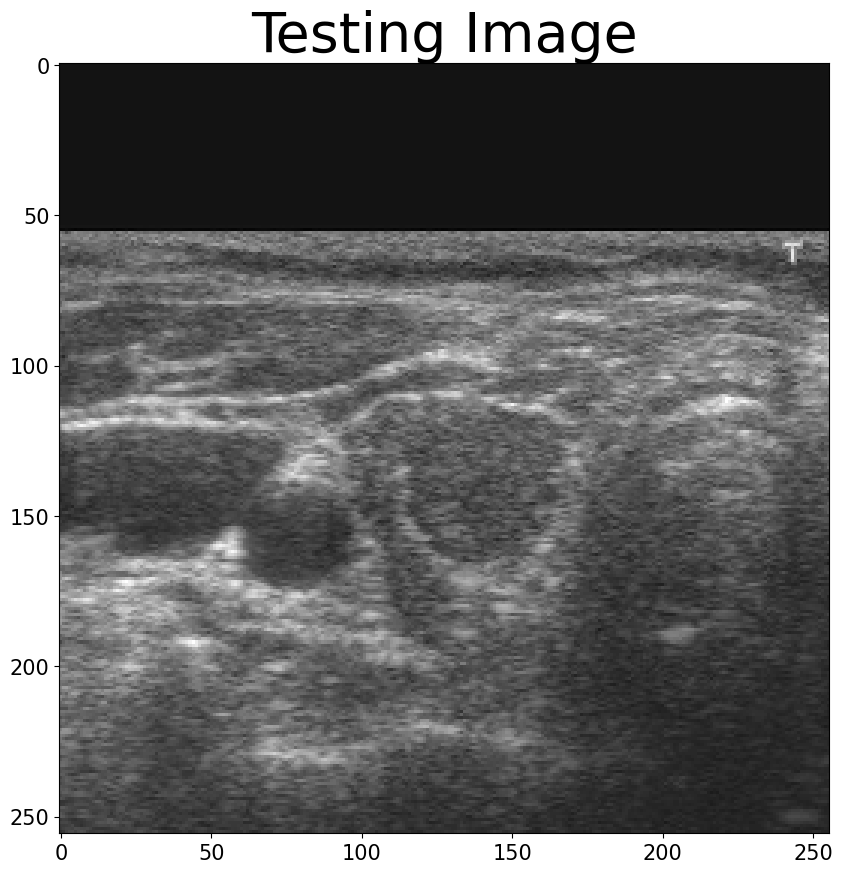

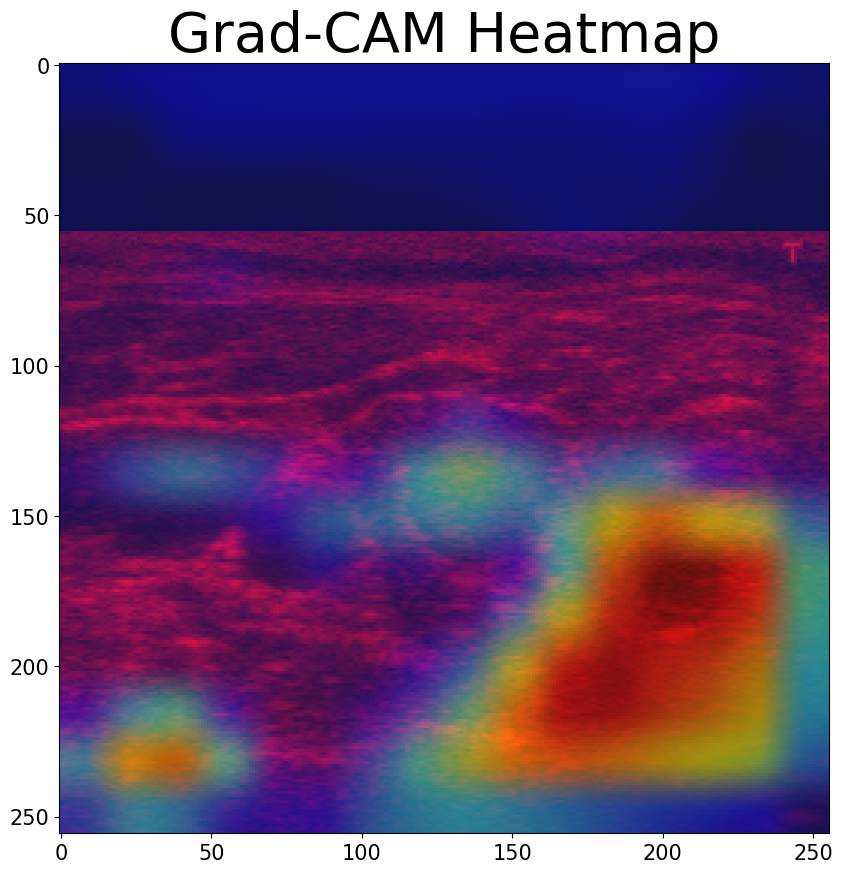

In [63]:
# Display Results
plt.figure(figsize=(20, 10))
plt.title("Testing Image", fontsize=40)
plt.imshow(np.squeeze(x_test[0]), cmap="gray")

plt.figure(figsize=(20, 10))
plt.title("Grad-CAM Heatmap", fontsize=40)
plt.imshow(superimposed_img)

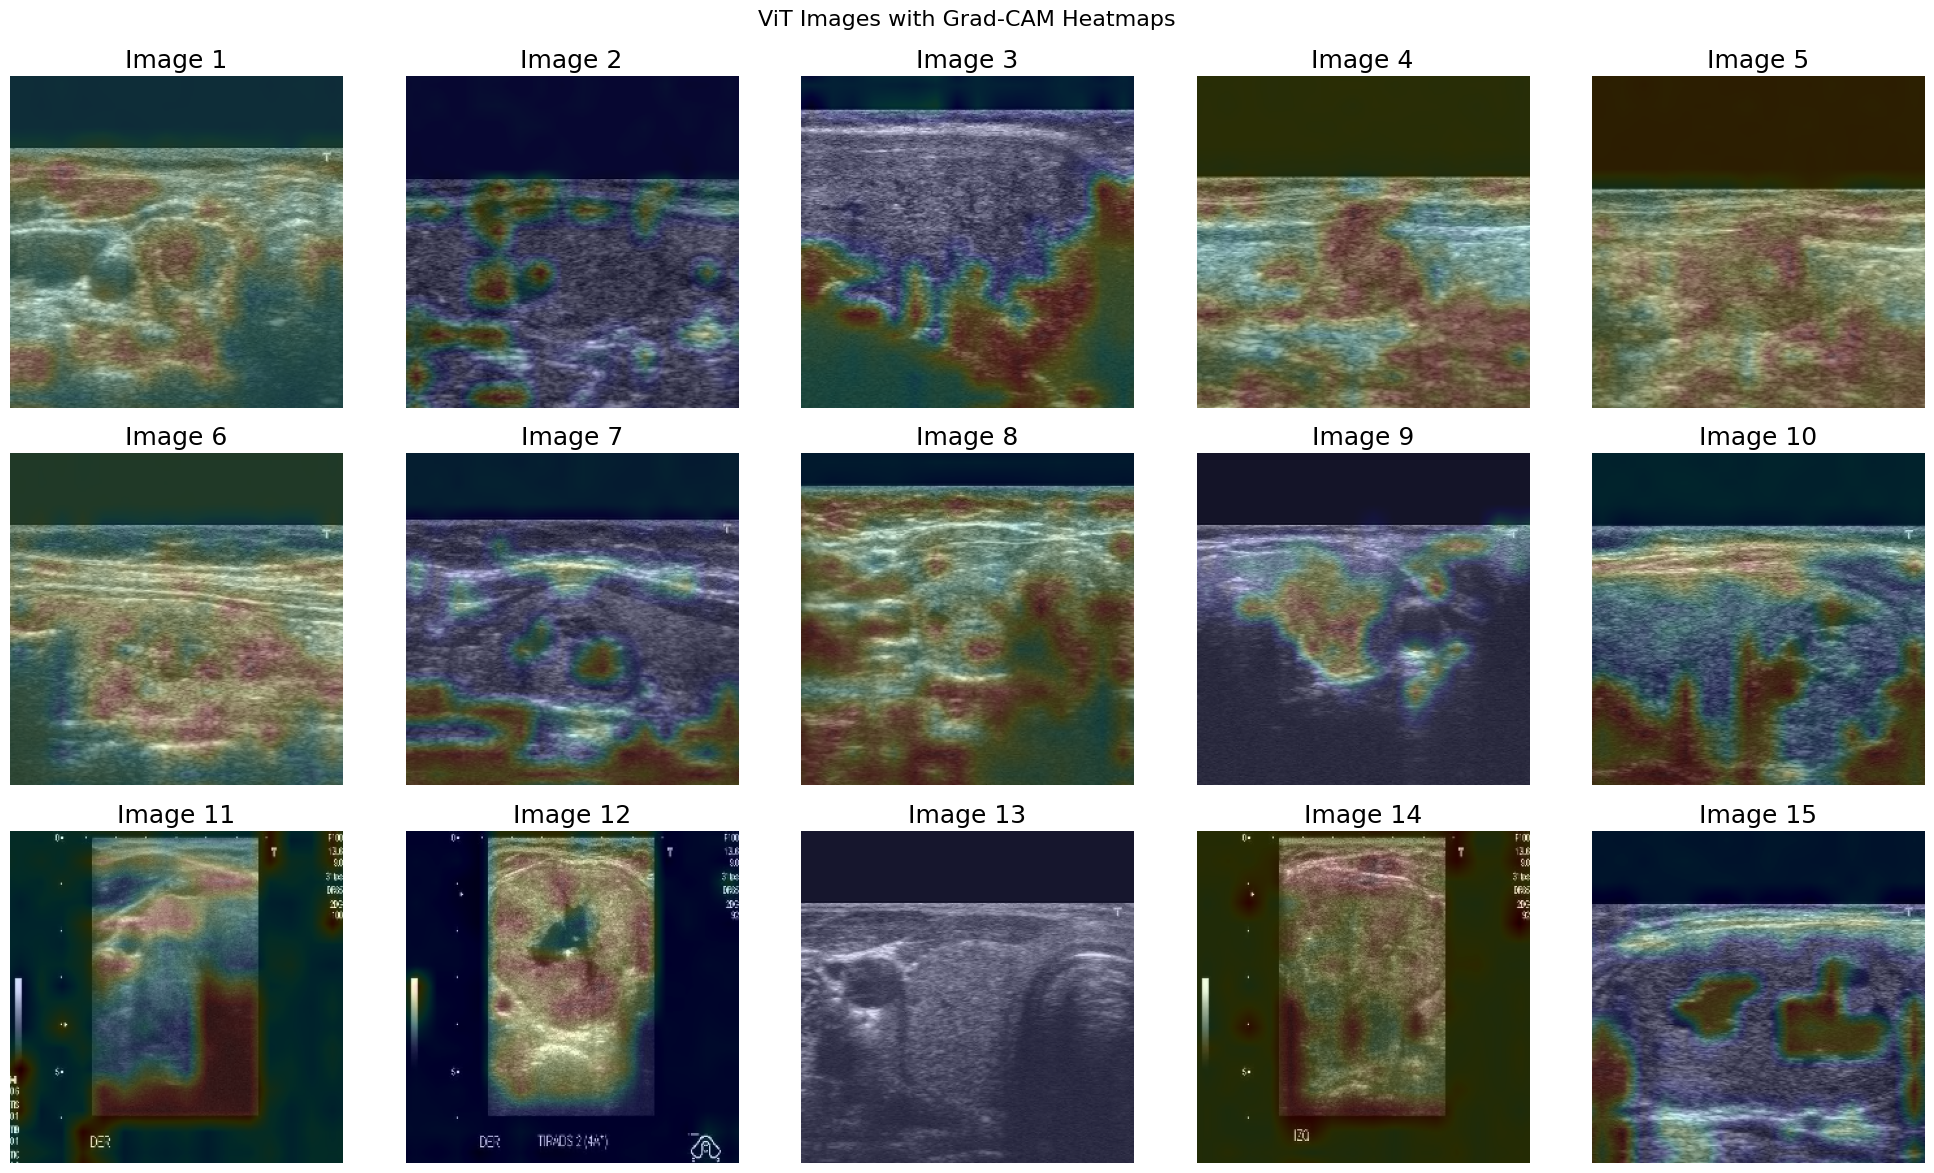

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

# Assuming you have already defined the functions make_gradcam_heatmap_vit and visualize_gradcam

def display_vit_images(x_test, vit_model, num_images=15):
    # Create a grid of subplots
    rows = 3
    cols = 5
    fig, axes = plt.subplots(rows, cols, figsize=(20, 12))
    fig.suptitle("ViT Images with Grad-CAM Heatmaps", fontsize=16)

    attention_layer_name = "multi_head_attention_7"  # Last Multi-Head Attention Layer
    classifier_layer_names = ["layer_normalization_16", "flatten", "dense_20", "dense_21", "dense_22"]  # Classifier layers

    for i in range(num_images):
        row = i // cols
        col = i % cols

        # Get the image
        img_array = np.expand_dims(x_test[i], axis=0)

        # Generate Grad-CAM heatmap
        heatmap = make_gradcam_heatmap_vit(
            img_array, vit_model, attention_layer_name, classifier_layer_names
        )

        # Visualize Grad-CAM
        superimposed_img = visualize_gradcam(img_array, heatmap)

        # Display the original image and heatmap side by side
        ax = axes[row, col]
        ax.imshow(np.squeeze(x_test[i]), cmap="gray")
        ax.imshow(superimposed_img, alpha=0.6)
        ax.axis('off')
        ax.set_title(f"Image {i+1}")

    plt.tight_layout()
    plt.show()

# Example usage
display_vit_images(x_test, vit_model)